In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_602_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1428_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1282_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_93_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_59_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1992_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1461_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_101_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_379_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_598_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1303_.jpg
/kaggle/input/semantic-segmen

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *


2025-11-11 12:25:13.466350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762863913.490382    3277 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762863913.497653    3277 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
color_map = {
    (0, 0, 0): 0,        # BW
    (0, 0, 255): 1,      # HD 
    (0, 255, 0): 2,      # PF 
    (255, 255, 0): 3,    # WR 
    (0, 0, 128): 4,      # RO 
    (255, 0, 255): 5,    # RI 
    (0, 255, 255): 6,    # FV 
    (255, 255, 255): 7   # SR
}

In [4]:
index_to_color = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (0, 255, 0),
    3: (255, 255, 0),
    4: (0, 0, 128),
    5: (255, 0, 255),
    6: (0, 255, 255),
    7: (255, 255, 255)
}

In [5]:
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for filename in os.listdir(os.path.join(image_dir, "images")):
        if filename.endswith(".jpg"):
            base_name = os.path.splitext(filename)[0]
            img_path = os.path.join(image_dir, "images", filename)
            mask_path = os.path.join(mask_dir, "masks", base_name + ".bmp")
            
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
    
    return image_paths, mask_paths


def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=25,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.5
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.3,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.2
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.3
        )
    ], additional_targets={'mask': 'image'})

def data_generator(image_paths, mask_paths, batch_size=8, image_size=(256, 256)):
    aug = get_augmentation()
    while True:
        indices = np.random.permutation(len(image_paths))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_masks = []
            
            for j in batch_indices:
                img = cv2.imread(image_paths[j])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR转RGB
                img = cv2.resize(img, image_size)
                img = img.astype(np.float32) / 255.0
                
                mask = cv2.imread(mask_paths[j])
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # BGR转RGB
                mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

                augmented = aug(image=img, mask=mask)
                img_aug = augmented['image']
                mask_aug = augmented['mask']
                
                class_mask = np.zeros(mask_aug.shape[:2], dtype=np.uint8)
                for color, idx in color_map.items():
                    class_mask[np.all(mask_aug == color, axis=-1)] = idx
                
                batch_images.append(img_aug)
                batch_masks.append(class_mask)
            
            yield np.array(batch_images), np.array(batch_masks)


In [6]:
def rgb_to_class(mask_rgb, color_map):
    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)
    class_mask = np.zeros((h*w,), dtype=np.uint8)
    
    color_arr = np.array(list(color_map.keys()))
    for i, pixel in enumerate(mask_flat):
        dist = np.sum((color_arr - pixel) ** 2, axis=1)
        class_mask[i] = list(color_map.values())[np.argmin(dist)]
    return class_mask.reshape(h, w)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout, concatenate, Resizing
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add

from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

def mean_iou_metric(y_true, y_pred):
    num_classes = 8
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    # Compute confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
    sum_over_row = tf.reduce_sum(cm, axis=0)
    sum_over_col = tf.reduce_sum(cm, axis=1)
    diag = tf.cast(tf.linalg.tensor_diag_part(cm), tf.float32)
    denominator = tf.cast(sum_over_row + sum_over_col, tf.float32) - diag
    iou = diag / (denominator + tf.keras.backend.epsilon())
    miou = tf.reduce_mean(iou)
    return miou

def cbam_block(feature_map, ratio=8):
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(feature_map)
    channel_max = GlobalMaxPooling2D()(feature_map)
    shared_dense_one = Dense(feature_map.shape[-1] // ratio, activation='relu')
    shared_dense_two = Dense(feature_map.shape[-1], activation='sigmoid')
    channel = Add()([
        shared_dense_one(channel_avg),
        shared_dense_one(channel_max)
    ])
    channel = shared_dense_two(channel)
    channel = Reshape((1, 1, feature_map.shape[-1]))(channel)
    channel_mul = Multiply()([feature_map, channel])
    # Spatial Attention
    spatial = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(channel_mul)
    cbam_feature = Multiply()([channel_mul, spatial])
    return cbam_feature

def UNetEfficientNetCBAM(input_size=(320, 320, 3), no_of_class=8):
    base_model = EfficientNetB0(input_shape=input_size, include_top=False, weights='imagenet')
    skips = [
        base_model.get_layer("block2a_expand_activation").output,
        base_model.get_layer("block3a_expand_activation").output,
        base_model.get_layer("block4a_expand_activation").output,
        base_model.get_layer("block6a_expand_activation").output,
    ]
    skips = [cbam_block(s) for s in skips]
    encoder_output = base_model.output

    x = encoder_output

    # Decoder block 1
    x = UpSampling2D((2, 2))(x)
    skips3_resized = Resizing(x.shape[1], x.shape[2])(skips[3])
    x = concatenate([x, skips3_resized])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    # Decoder block 2
    x = UpSampling2D((2, 2))(x)
    skips2_resized = Resizing(x.shape[1], x.shape[2])(skips[2])
    x = concatenate([x, skips2_resized])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    # Decoder block 3
    x = UpSampling2D((2, 2))(x)
    skips1_resized = Resizing(x.shape[1], x.shape[2])(skips[1])
    x = concatenate([x, skips1_resized])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    # Decoder block 4
    x = UpSampling2D((2, 2))(x)
    skips0_resized = Resizing(x.shape[1], x.shape[2])(skips[0])
    x = concatenate([x, skips0_resized])
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    # Final upsampling to restore input size
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Resizing(input_size[0], input_size[1])(x)
    outputs = Conv2D(no_of_class, 1, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # masks: (batch, H, W, 1) integer labels 0..7
        metrics=[SparseCategoricalAccuracy(name='accuracy'), mean_iou_metric]
    )
    model.summary()
    return model

In [8]:
IMAGE_SIZE = IMAGE_SIZE = (256,256)
BATCH_SIZE = 4
EPOCHS = 200


# --- Load training/validation data ---
train_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"
train_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"

train_image_paths, train_mask_paths = load_data(train_image_dir, train_mask_dir)

# Split train_val into training and validation (e.g. 80/20)
train_img, val_img, train_msk, val_msk = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42
)

# --- Load separate test data ---
test_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"
test_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"

test_image_paths, test_mask_paths = load_data(test_image_dir, test_mask_dir)


In [9]:
def sparse_combined_loss(y_true, y_pred, alpha=0.5, num_classes=8):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_oh = tf.nn.softmax(y_pred)
    
    intersection = tf.reduce_sum(y_true_oh * y_pred_oh, axis=[1,2])
    union = tf.reduce_sum(y_true_oh + y_pred_oh, axis=[1,2])
    dice_loss = 1 - tf.reduce_mean((2. * intersection + 1e-7)/(union + 1e-7))
    
    gamma = 2.0
    focal_loss = tf.reduce_mean(-(1-y_pred_oh)**gamma * tf.math.log(y_pred_oh + 1e-7))
    
    return alpha*ce_loss + (0.5-alpha)*dice_loss + 0.2*focal_loss

In [10]:
def calculate_metrics(true_mask, pred_mask, num_classes):

    dice = np.zeros(num_classes)
    iou = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for cls in range(num_classes):
        true_cls = (true_mask == cls)
        pred_cls = (pred_mask == cls)
        
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        true_sum = true_cls.sum()
        pred_sum = pred_cls.sum()
        
        dice[cls] = (2. * intersection) / (true_sum + pred_sum + 1e-7)
        
        # IoU
        iou[cls] = intersection / (union + 1e-7)
        
        # F1
        precision = intersection / (pred_sum + 1e-7)
        recall = intersection / (true_sum + 1e-7)
        f1[cls] = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return dice, iou, f1


In [11]:
def visualize_results(image_path, mask_path, model, size=(256,256)):
    # 1.（BGR→RGB）
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    orig_size = img.shape[:2]
    img = cv2.resize(img, size)
    img_input = img.astype(np.float32)/255.0
    img_input = np.expand_dims(img_input, axis=0)
    
    # 2. predict
    pred = model.predict(img_input)[0]
    pred_mask = np.argmax(pred, axis=-1)
    
    # 3. mask（BGR→RGB）
    true_mask = cv2.imread(mask_path)
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)  
    true_mask = cv2.resize(true_mask, size, interpolation=cv2.INTER_NEAREST)
    
    true_class = np.zeros(true_mask.shape[:2], dtype=np.uint8)
    for color, idx in color_map.items(): 
        true_class[np.all(true_mask == color, axis=-1)] = idx
    
    
    pred_color = np.zeros((*size, 3), dtype=np.uint8)
    true_color = np.zeros((*size, 3), dtype=np.uint8)
    
    for idx, color in index_to_color.items():  
        pred_color[pred_mask == idx] = color
        true_color[true_class == idx] = color
    
   
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img) 
    plt.title("Original Image")
    
    plt.subplot(1,3,2)
    plt.imshow(true_color)
    plt.title("True Mask")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.show()

In [12]:
train_gen = data_generator(train_img, train_msk, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(val_img, val_msk, BATCH_SIZE, IMAGE_SIZE)


model = UNetEfficientNetCBAM(input_size=IMAGE_SIZE + (3,))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=sparse_combined_loss,
             metrics=['accuracy']
             )
model.summary()

I0000 00:00:1762863916.949610    3277 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762863916.950347    3277 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 10,316,735 (39.36 MB)

 Trainable params: 10,274,712 (39.19 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 10,316,735 (39.36 MB)

 Trainable params: 10,274,712 (39.19 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
train_gen = data_generator(train_img, train_msk, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(val_img, val_msk, BATCH_SIZE, IMAGE_SIZE)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_img)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_img)//BATCH_SIZE,
    epochs=EPOCHS
)


val_dice = []
val_iou = []
val_f1 = []

for i in range(len(val_img)//BATCH_SIZE):
    x_val, y_val = next(val_gen)
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    for j in range(len(y_val)):
        true_mask = y_val[j]
        pred_mask = y_pred[j]
        dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
        val_dice.append(dice)
        val_iou.append(iou)
        val_f1.append(f1)

avg_val_dice = np.mean(val_dice, axis=0)
avg_val_iou = np.mean(val_iou, axis=0)
avg_val_f1 = np.mean(val_f1, axis=0)

class_names = list(index_to_color.keys())
for cls, name in enumerate(class_names):
    print(f"Class {name}:")
    print(f"  Dice: {avg_val_dice[cls]:.4f}")
    print(f"  IoU: {avg_val_iou[cls]:.4f}")
    print(f"  F1: {avg_val_f1[cls]:.4f}")
    print()

mIoU = np.mean(avg_val_iou)
avg_dice = np.mean(avg_val_dice)
print(f"mIoU: {mIoU:.4f}")
print(f"Average Dice: {avg_dice:.4f}")


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch 1/200


I0000 00:00:1762863983.992301    3335 service.cc:148] XLA service 0x783748001f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762863983.992357    3335 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762863983.992362    3335 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1762863987.600899    3335 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1762863990.169065    3335 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762863995.300043    3335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762863995.438942    3335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal

  1/305 ━━━━━━━━━━━━━━━━━━━━ 9:42:21 115s/step - accuracy: 0.1853 - loss: 1.3254

I0000 00:00:1762864034.880596    3335 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4915 - loss: 1.0388

W0000 00:00:1762864077.744826    3334 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


305/305 ━━━━━━━━━━━━━━━━━━━━ 172s 186ms/step - accuracy: 0.4917 - loss: 1.0386 - val_accuracy: 0.5270 - val_loss: 0.9989
Epoch 2/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.6041 - loss: 0.8986 - val_accuracy: 0.5644 - val_loss: 0.9552
Epoch 3/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.6053 - loss: 0.8730 - val_accuracy: 0.5887 - val_loss: 0.9365
Epoch 4/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6264 - loss: 0.8381

W0000 00:00:1762864217.476646    3336 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1762864218.070104    3336 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762864218.203004    3336 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


305/305 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.6264 - loss: 0.8381 - val_accuracy: 0.4866 - val_loss: 1.1799
Epoch 5/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - accuracy: 0.6487 - loss: 0.8113 - val_accuracy: 0.6079 - val_loss: 0.9123
Epoch 6/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 43s 141ms/step - accuracy: 0.6756 - loss: 0.7823 - val_accuracy: 0.2622 - val_loss: 1.5824
Epoch 7/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.6743 - loss: 0.7806 - val_accuracy: 0.4575 - val_loss: 1.0465
Epoch 8/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.6829 - loss: 0.7586 - val_accuracy: 0.6499 - val_loss: 0.8354
Epoch 9/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.6943 - loss: 0.7553 - val_accuracy: 0.5425 - val_loss: 1.0053
Epoch 10/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.7031 - loss: 0.7373 - val_accuracy: 0.5534 - val_loss: 1.0956
Epoch 11/200
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.7244 - loss: 0.7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


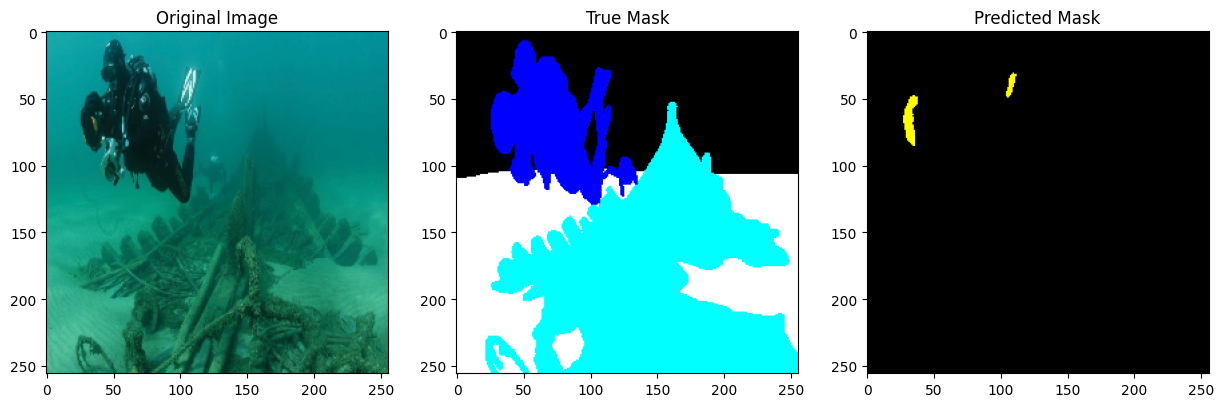

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


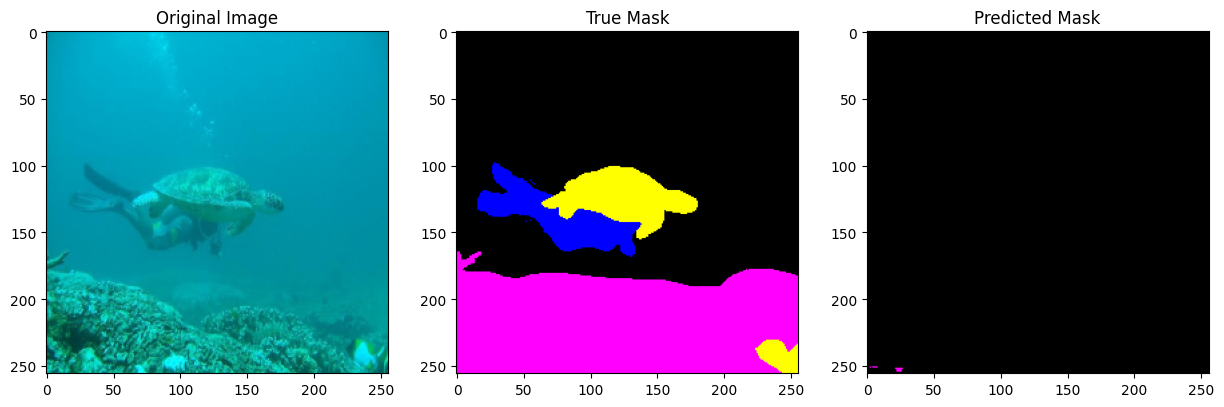

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


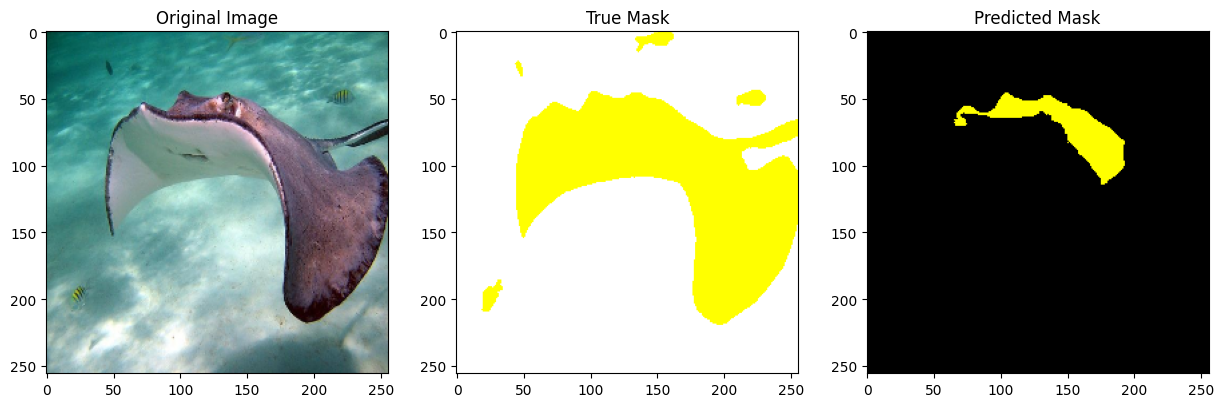

In [14]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model)

In [15]:
test_dice, test_iou, test_f1 = [], [], []

for i in range(len(test_image_paths)):
    img = cv2.imread(test_image_paths[i])
    mask = cv2.imread(test_mask_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img_input = np.expand_dims(img.astype(np.float32)/255.0, axis=0)

    pred = model.predict(img_input)[0]
    pred_mask = np.argmax(pred, axis=-1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

    true_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    for color, idx in color_map.items():
        true_mask[np.all(mask == color, axis=-1)] = idx

    dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
    test_dice.append(dice)
    test_iou.append(iou)
    test_f1.append(f1)

print("Test mIoU:", np.mean(test_iou))
print("Test Dice:", np.mean(test_dice))
print("Test F1:", np.mean(test_f1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

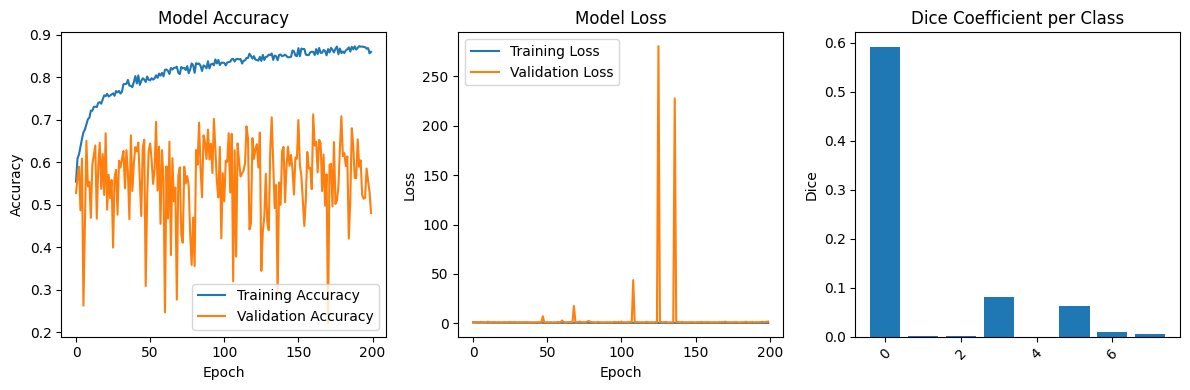

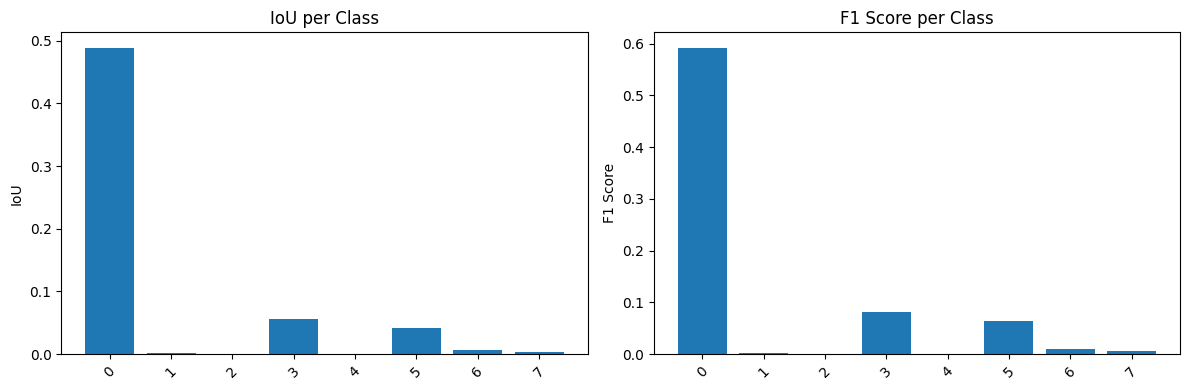

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 3, 3)
plt.bar(class_names, avg_val_dice)
plt.title('Dice Coefficient per Class')
plt.ylabel('Dice')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 4))

# IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, avg_val_iou)
plt.title('IoU per Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)

# F1
plt.subplot(1, 2, 2)
plt.bar(class_names, avg_val_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


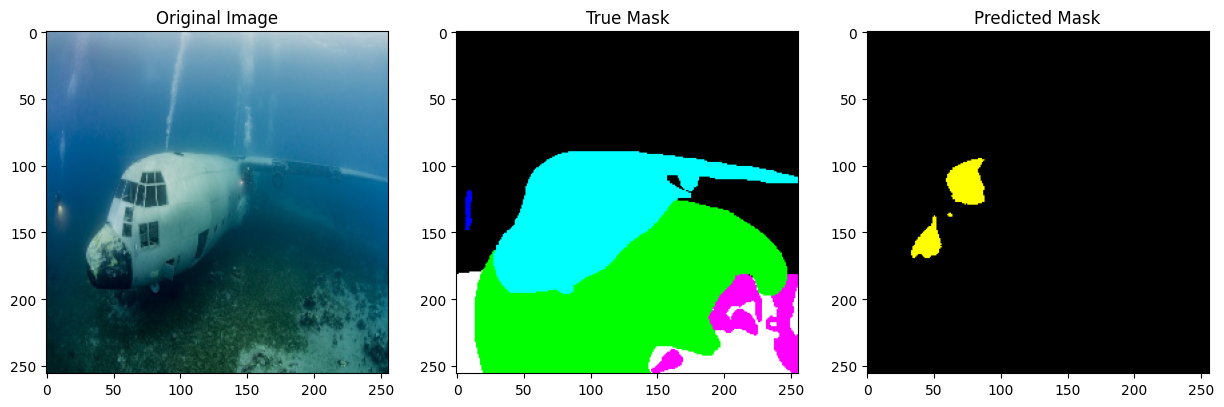

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


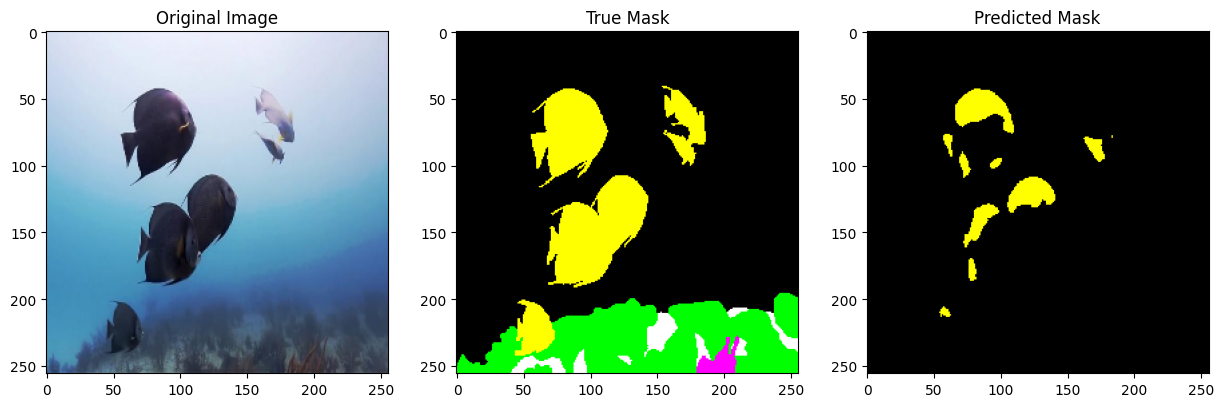

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


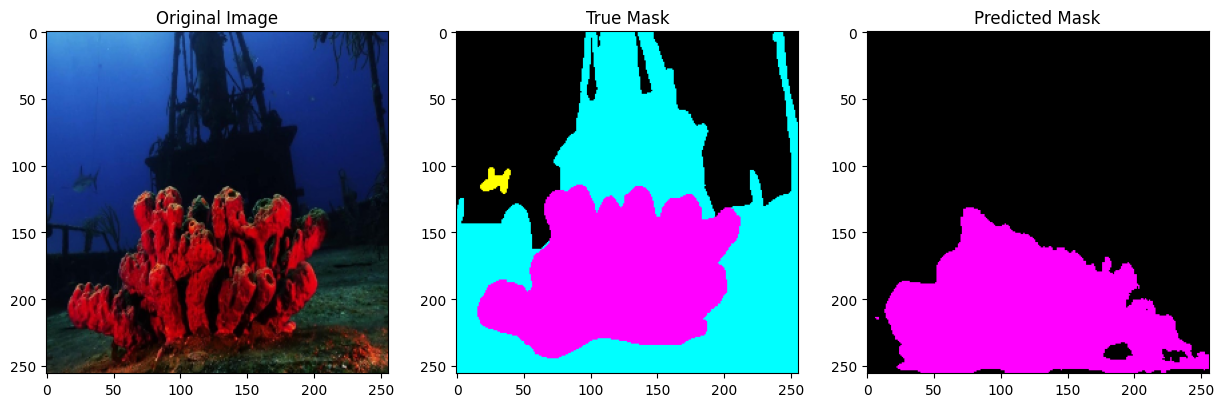

In [17]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model)